In [12]:
# Uncomment and run this when using colab. 
#%pip install pygeoinf

# Tutorial 7 - Bayesian inversions

Building on Tutorial 6, we consider in furter detail the solution on our linear inverse problem using Bayesian methods. The set up of the foward problem is identical:

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pygeoinf as inf
from pygeoinf.symmetric_space.circle import Sobolev

# Set the Sobolev parameters for the model space. 
order = 2.0
length_scale = 0.05

# Set the model space. 
model_space = Sobolev.from_sobolev_parameters(order, length_scale, power_of_two=True)

print(f'The discretised model space has dimension: {model_space.dim}')

# Set up the observation points. 
n = 30
observation_points = np.random.uniform(0, 2*np.pi, n)

# Set the forward operator
forward_operator = model_space.point_evaluation_operator(observation_points)

# Set the data space. 
data_space = forward_operator.codomain

print(f'The data space has dimension: {data_space.dim}')

# First define a Gaussian measure on the model space. 
error_length_scale = 0.2
error_amplitude = 0.1
mu = model_space.heat_gaussian_measure(error_length_scale, error_amplitude)

# Push forward the measure under the forward operator. 
nu = mu.affine_mapping(operator=forward_operator)

# Extract the covariance matrix and use this to define the desired measure. 
covariance_matrix = nu.covariance.matrix(dense=True)
data_error_measure = inf.GaussianMeasure.from_covariance_matrix(data_space, covariance_matrix)

# Get the standard deviations for each datum for use in plotting. 
standard_deviations = np.zeros(data_space.dim)
for i in range(data_space.dim):
    v = data_space.basis_vector(i)
    standard_deviations = np.sqrt(data_space.inner_product(data_error_measure.covariance(v), v))

# Set the forward problem. 
forward_problem = inf.LinearForwardProblem(forward_operator, data_error_measure)

The discretised model space has dimension: 2048
The data space has dimension: 30


The main new feature within the Bayesian approach to the inverse problem is the specification of a prior measure on the model space. Here we select the expectation of the prior directly and chose its covariance from one the standard options that have been implemented within the ```Sobolev``` class. 

In [14]:
# Set the model prior expectation. 
expectation = model_space.project_function(lambda th: 2* np.sin(6*th) * np.exp(-(th-np.pi)**2) )

# Set the model prior. 
covariance_length_scale = 0.05
covariance_amplitude = 0.3
model_prior_measure = model_space.heat_gaussian_measure(covariance_length_scale, covariance_amplitude, expectation=expectation)

Using this measure, we can generate a model and corresponding data:

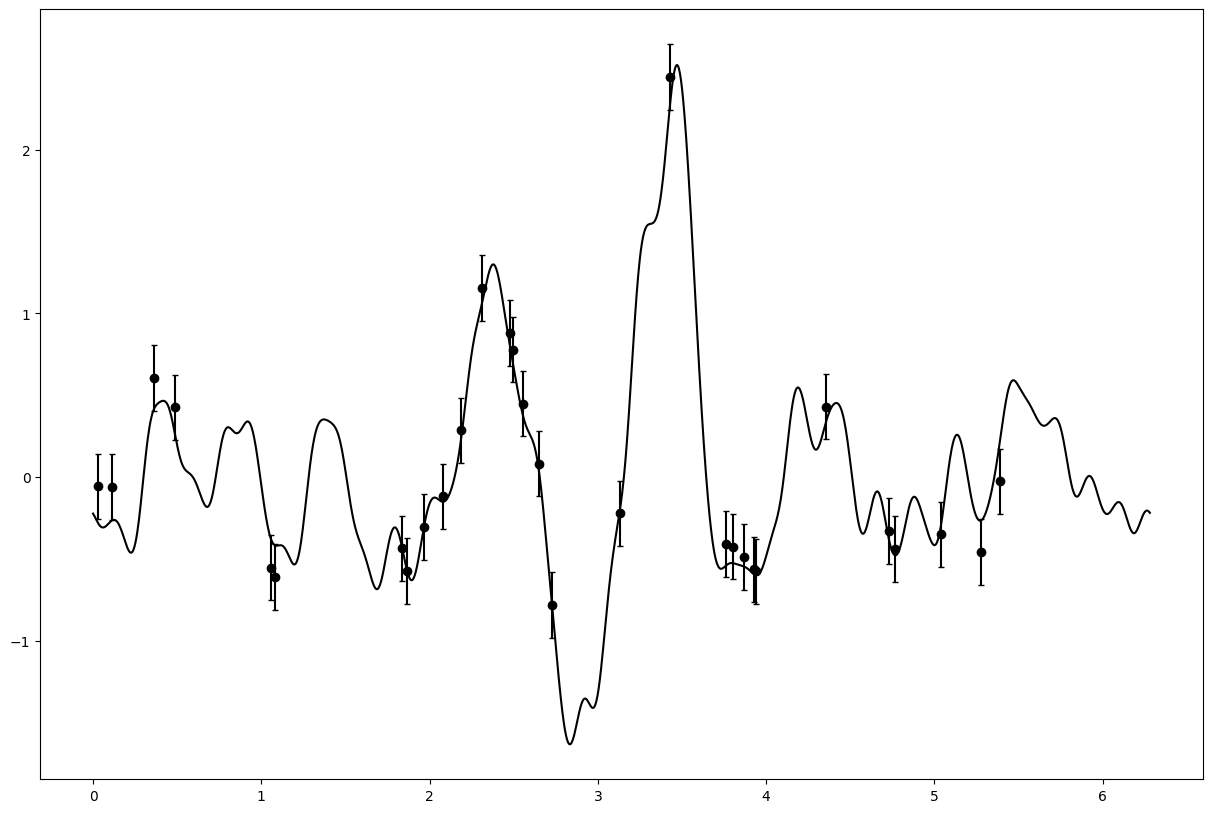

In [15]:
model, data = forward_problem.synthetic_model_and_data(model_prior_measure)

# Plot the model and associated data. 
fig, ax = model_space.plot(model, color="k", figsize=(15, 10))
ax.errorbar(observation_points, data, 2 * standard_deviations, fmt="ko", capsize=2)
plt.show()


To set up the ```LinearBayesianInversion``` class we provide the forward problem and the model prior:

In [16]:
bayesian_inversion = inf.LinearBayesianInversion(forward_problem, model_prior_measure)

It can be shown that the model posterior measure is also Gaussian with expectation
$$
\overline{u}_{\mathrm{post}} = \overline{u} +  Q A^{*} (AQA^{*} + R)^{-1}(v - A\overline{u}) 
$$
and covariance
$$
Q_{\mathrm{post}} = Q - Q A^{*} (AQA^{*} + R)^{-1} AQ, 
$$
where $\overline{u}$ is the prior expectation and $Q$ the prior covariance. We call $AQA^{*}+R$ the **normal operator** for this problem. It can be accessed through:

In [17]:
normal_operator = bayesian_inversion.normal_operator

Direct access to this operator is potentially useful in building preconditioners. Note that this operator is self-adjoint, positive-definite, and defined on the finite-dimensional model space which, in almost all cases, will be standard Euclidean space.

To solve the Bayesian inverse problem we use the method ```model_posterior_measure``` which takes as input the data and a ```LinearSolver``` and returns the desired measure. Optionally, a preconditioner for the normal operator can be provided that can be used in combination with an ```IterativeLinearSolver```.

When the dimension of the data space is relatively small, it is often sufficient to use a simple Cholesky solver. This has a comparatively high upfront cost of forming and factoring the dense matrix representation, but once this is done the action of the posterior covariance can be determined at a low cost. 

In the code below we obtain the posterior measure and compare its expected value to the true model. 

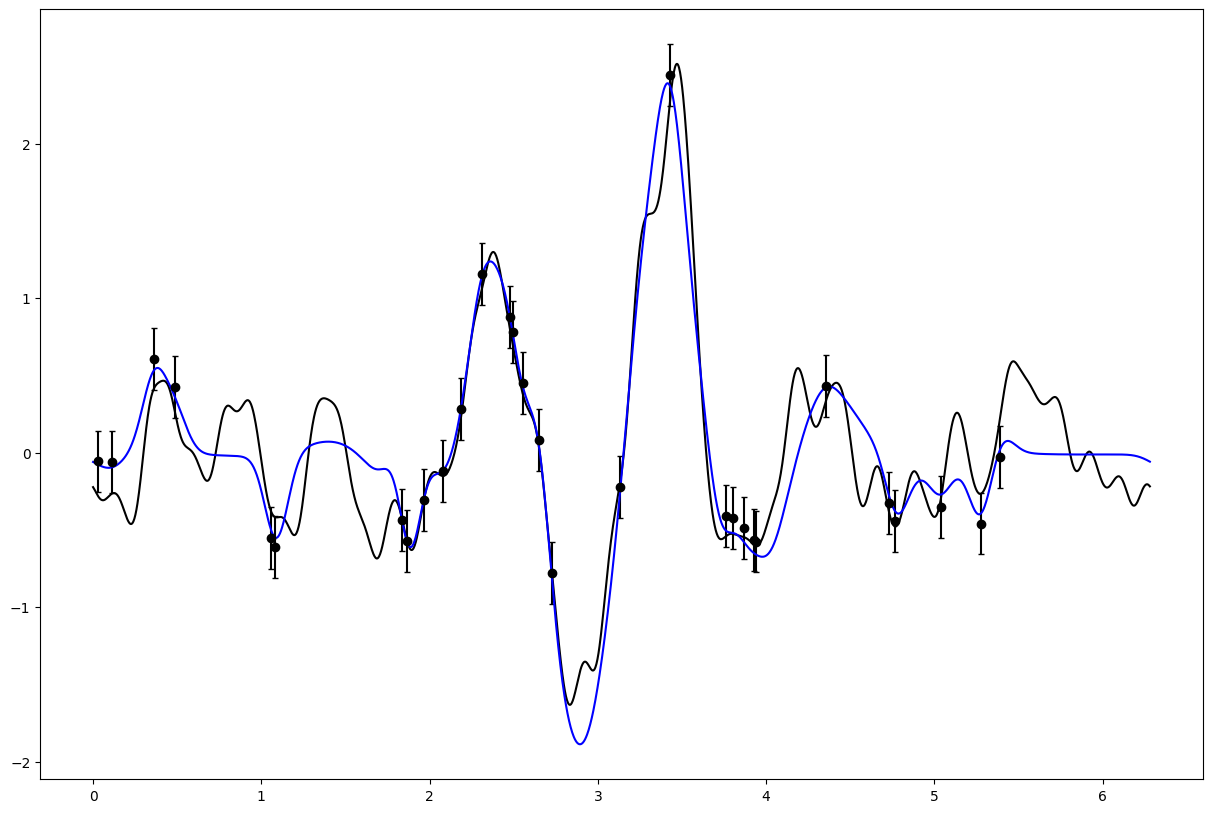

In [18]:
# Get the posterior distribution. 
solver = inf.CholeskySolver()
model_posterior_measure = bayesian_inversion.model_posterior_measure(data, solver)

# Plot the posterior expectation. 
# Plot the model and associated data and the least squares solution.
fig, ax = model_space.plot(model, color="k", figsize=(15, 10))
ax.errorbar(observation_points, data , 2 * standard_deviations, fmt="ko", capsize=2)
model_space.plot(model_posterior_measure.expectation, color="b", fig=fig, ax=ax)
plt.show()

The posterior measure returned by the ```LinearBayesianInversion``` class does not have a covariance in factored form nor otherwise have a sampling method set. The action of this covariance on any given pair of model vectors can be readily computed, and hence we can explore the uncertainty along directions in the model space. 

To gain a fuller understanding of the model uncertainty, one option is to compute the posterior covariance in dense form and then factor it so as to allow for sampling. The cost of this calculation will, however, generally be very high as due to the model space dimension. A typically preferable method is based on a low rank Cholesky factorisation of the posterior covariance. This is implemented in the method ```low_rank_approximation``` within the ```GaussianMeasure``` class. The factorisation is done using randomised methods, and can be based on either a fixed or variable rank factorisation. 

In the code below we use a variable rank factorisation, setting also the relative tolerance in estimating the associated error:

In [19]:
low_rank_posterior_approximation = model_posterior_measure.low_rank_approximation(10, method="variable", rtol=1e-6)

Once this low rank approximation is formed, we can readily sample from the posterior to learn about data uncertainties. For example, we can plot a set of samples:

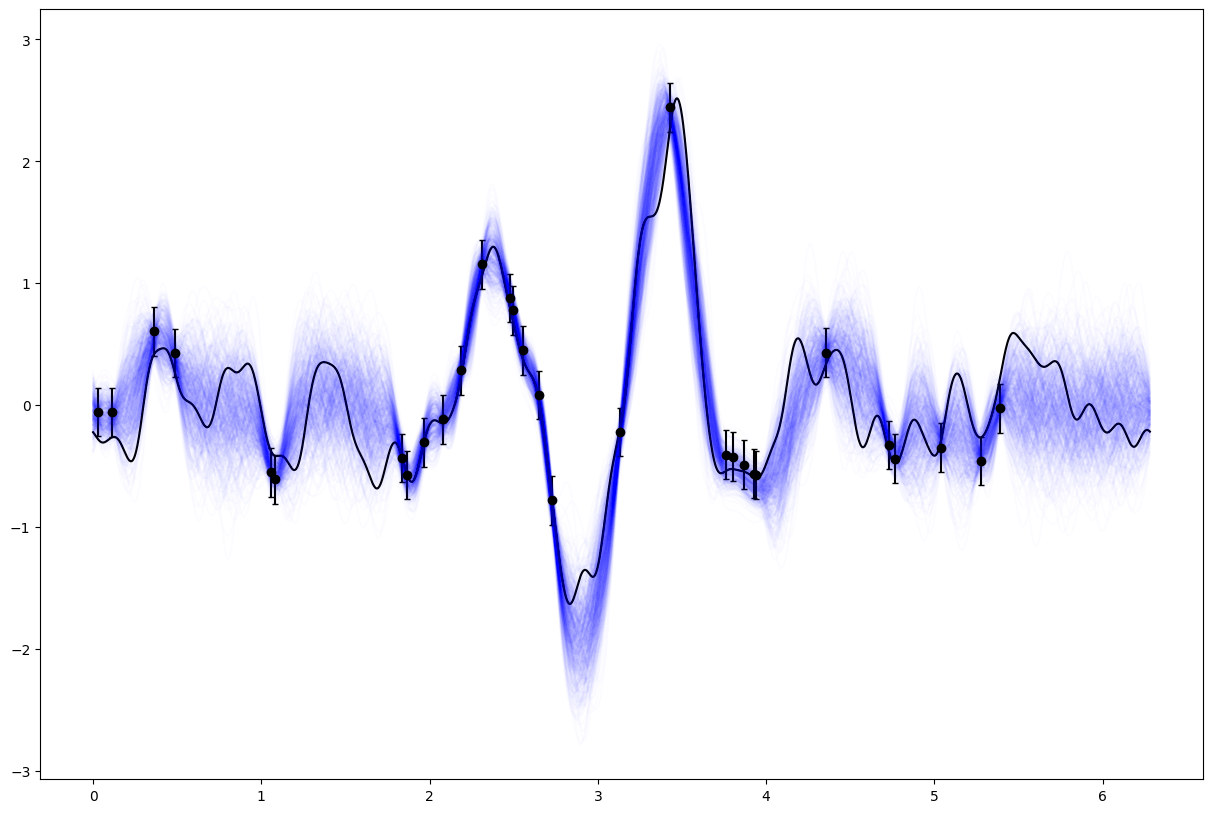

In [20]:
fig, ax = model_space.plot(model, color="k", figsize=(15, 10))
ax.errorbar(observation_points, data , 2 * standard_deviations, fmt="ko", capsize=2)

number_of_samples = 500
samples = low_rank_posterior_approximation.samples(number_of_samples)
for sample in samples:    
    model_space.plot(sample, color="b", fig=fig, ax=ax, alpha=5/number_of_samples)
    

plt.show()

We can also use a set of such samples to estimate the pointwise standard deviation for the the posterior measure:

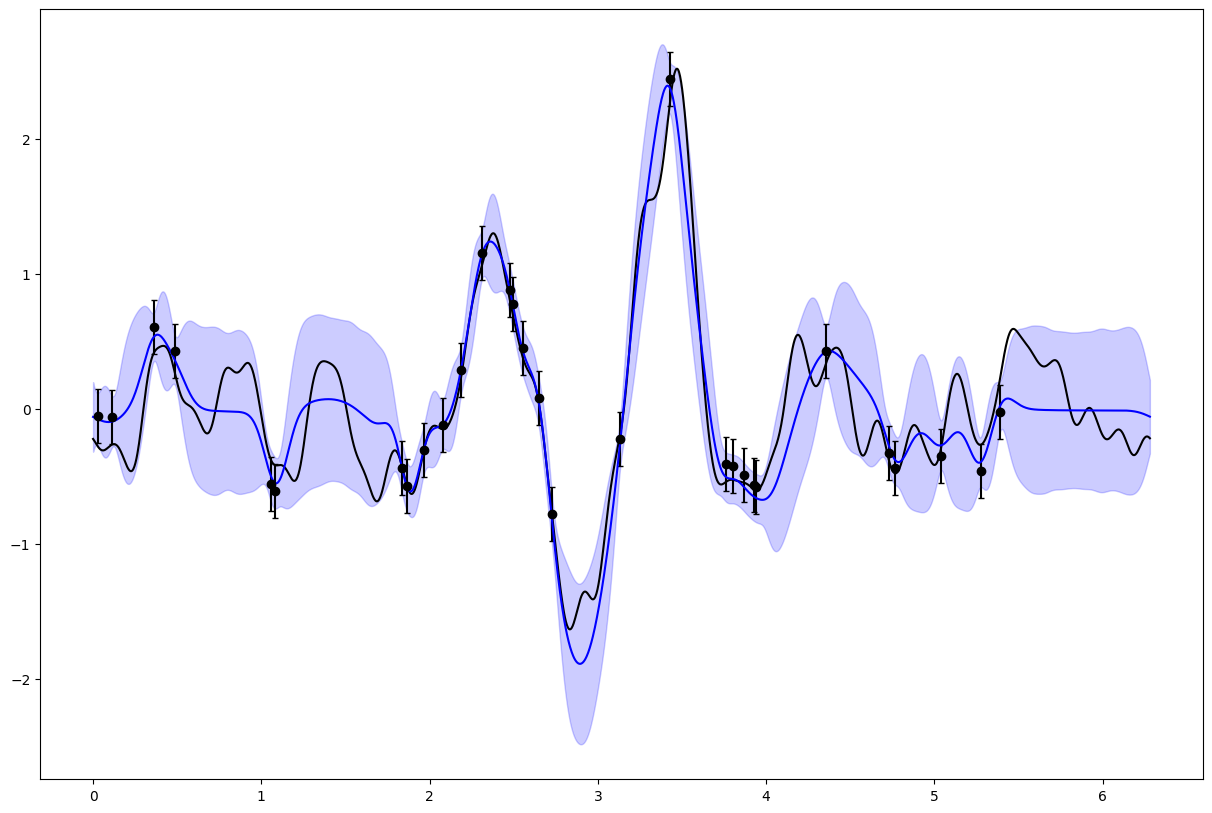

In [21]:
model_pointwise_variance = low_rank_posterior_approximation.sample_pointwise_variance(number_of_samples)
model_pointwise_std = np.sqrt(model_pointwise_variance)


# Plot the
fig, ax = model_space.plot(model, color="k", figsize=(15,10))
ax.errorbar(observation_points, data, 2 * standard_deviations, fmt="ko", capsize=2)
model_space.plot(
    model_posterior_measure.expectation, fig=fig, ax=ax, color="b"
)
model_space.plot_error_bounds(
    model_posterior_measure.expectation,
    2 * model_pointwise_std,
    fig=fig,
    ax=ax,
    alpha=0.2,
    color="b",
)
plt.show()

A significant appeal of Bayesian methods is that they provide a measure of uncertainty on the models produced. But it must be rememebered that these answers are only as good as the prior probability distribution, and that within inverse problems there is rarely enough data for the choice of prior to be immaterial. 

In the code below, we repeat the calculations above, using the same model and data, but now using a different prior. 

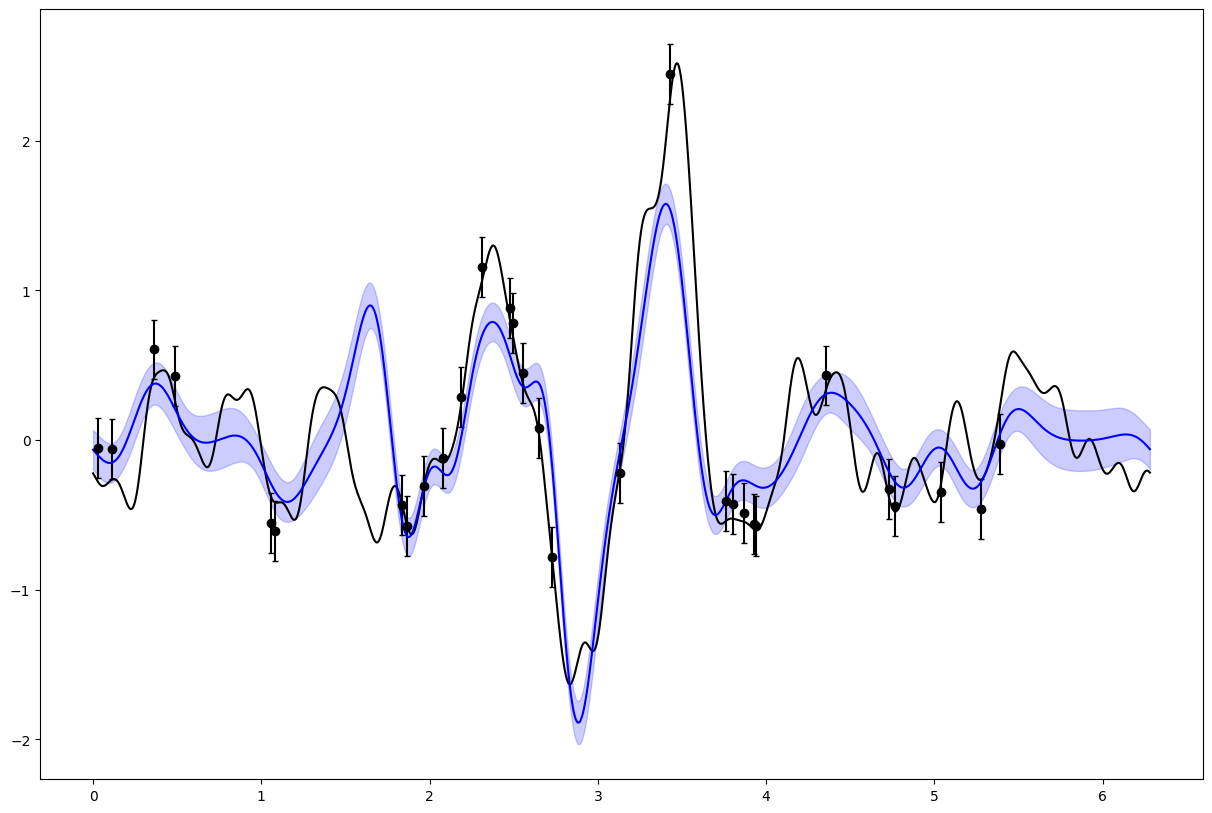

In [22]:
# Set the new model prior. 
new_covariance_length_scale = 0.1
new_covariance_amplitude = 0.1
new_model_prior_measure = model_space.heat_gaussian_measure(new_covariance_length_scale, new_covariance_amplitude)

# Set up the inversion and form the posterior.
new_bayesian_inversion = inf.LinearBayesianInversion(forward_problem, new_model_prior_measure)
new_model_posterior_measure = new_bayesian_inversion.model_posterior_measure(data, solver)

# Form the low rank approximation
new_low_rank_posterior_approximation = new_model_posterior_measure.low_rank_approximation(10, method="variable", rtol=1e-6)

# Plot the posterior expectation with uncertainty bounds.

new_model_pointwise_variance = new_low_rank_posterior_approximation.sample_pointwise_variance(number_of_samples)
new_model_pointwise_std = np.sqrt(new_model_pointwise_variance)


# Plot the
fig, ax = model_space.plot(model, color="k", figsize=(15,10))
ax.errorbar(observation_points, data, 2 * standard_deviations, fmt="ko", capsize=2)
model_space.plot(
    new_model_posterior_measure.expectation, fig=fig, ax=ax, color="b"
)
model_space.plot_error_bounds(
    new_model_posterior_measure.expectation,
    2 * new_model_pointwise_std,
    fig=fig,
    ax=ax,
    alpha=0.2,
    color="b",
)
plt.show()
